In [200]:
#Imported necessary libraries and functions
import numpy as np
import pandas as pd 
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
%matplotlib inline

In [201]:
#Read all data into dataframes and SQL connection
cast = sqlite3.connect('zippedData/im.db')
#df_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
#df_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep='\t')
df_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding = 'windows-1252')
#df_popular = pd.read_csv("zippedData/tmdb.movies.csv.gz")
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

In [202]:
#Converted all movie titles to strings, since some movies were read as integers
df_budget['movie'] = df_budget['movie'].astype(str)

#Removed all special characters from titles and made them all lower case to increase chances of matching other similar values in other databases
spec_char = r'[^\w\s]'
df_budget['movie'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_budget['movie'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_budget['movie'] = df_budget['movie'].str.lower()

#Converted release dates to datetime
df_budget['release_date']= pd.to_datetime(df_budget['release_date'])

#Cleaned budget, domestic gross, and worlwide gross columns to integers
df_budget['production_budget'] = df_budget['production_budget'].str.replace(',', '')
df_budget['production_budget'] = df_budget['production_budget'].str.replace('$', '')
df_budget['production_budget'] = df_budget['production_budget'].astype(np.int64)
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace(',', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].str.replace('$', '')
df_budget['domestic_gross'] = df_budget['domestic_gross'].astype(np.int64)
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace(',', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].str.replace('$', '')
df_budget['worldwide_gross'] = df_budget['worldwide_gross'].astype(np.int64)

df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,avatar,425000000,760507625,2776345279
1,2,2011-05-20,piratesofthecaribbeanonstrangertides,410600000,241063875,1045663875
2,3,2019-06-07,darkphoenix,350000000,42762350,149762350
3,4,2015-05-01,avengersageofultron,330600000,459005868,1403013963
4,5,2017-12-15,starwarsepviiithelastjedi,317000000,620181382,1316721747


In [203]:
#Added profit columns
df_budget['worldwide_profit'] = df_budget['worldwide_gross'] - df_budget['production_budget']
df_budget['domestic_profit'] = df_budget['domestic_gross'] - df_budget['production_budget']

#Sorted data by highest domestic profits
df_budget.sort_values(by = ['domestic_profit'], ascending = False, inplace = True)

#Description of numerical data without scientific notation and rounding to the 2nd decimal place
df_budget.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
count,5782.00,5782.00,5782.00,5782.00,5782.00,5782.00
mean,50.37,31587757.10,41873326.87,91487460.91,59899703.81,10285569.77
std,28.82,41812076.83,68240597.36,174719968.78,146088881.08,49921366.46
min,1.00,1100.00,0.00,0.00,-200237650.00,-307237650.00
25%,25.00,5000000.00,1429534.50,4125414.75,-2189070.75,-9132757.00
50%,50.00,17000000.00,17225945.00,27984448.50,8550285.50,-348775.50
75%,75.00,40000000.00,52348661.50,97645836.50,60968501.75,17781444.00
max,100.00,425000000.00,936662225.00,2776345279.00,2351345279.00,630662225.00


In [204]:
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,domestic_profit
5,6,2015-12-18,starwarsepviitheforceawakens,306000000,936662225,2053311220,1747311220,630662225
41,42,2018-02-16,blackpanther,200000000,700059566,1348258224,1148258224,500059566
42,43,1997-12-19,titanic,200000000,659363944,2208208395,2008208395,459363944
3464,65,1977-05-25,starwarsepivanewhope,11000000,460998007,786598007,775598007,449998007
33,34,2015-06-12,jurassicworld,215000000,652270625,1648854864,1433854864,437270625


In [205]:
%%bash 

sqlite3 zippedData/im.db
.tables

directors      movie_akas     movie_ratings  principals   
known_for      movie_basics   persons        writers      


In [206]:
#Created a query that extracted the necessary information from the im.db file
review_query = """
    SELECT movie_basics.primary_title AS title, movie_basics.genres AS genres, 
    movie_ratings.averagerating AS average_rating, movie_ratings.numvotes AS num_votes, movie_akas.region AS region
    FROM movie_basics
    JOIN movie_ratings
        ON movie_basics.movie_id = movie_ratings.movie_id
    JOIN movie_akas
        ON movie_basics.movie_id = movie_akas.movie_id
    WHERE region = 'US'
    ORDER BY movie_ratings.averagerating DESC
"""

#Converted SQL query to Pandas Dataframe
df_reviews = pd.read_sql(review_query, cast)

#Removed all special characters from titles and made them all lower case to increase chances of matching other similar values in other databases
df_reviews['title'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_reviews['title'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_reviews['title'] = df_reviews['title'].str.lower()

#Replaced NaNs in genres column with a placeholder string so it can be iterable when converted to a dictionary
df_reviews['genres'] = df_reviews['genres'].fillna('Unknown')
df_reviews.drop_duplicates(subset = 'title', keep = 'first', inplace = True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25785 entries, 0 to 30193
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           25785 non-null  object 
 1   genres          25785 non-null  object 
 2   average_rating  25785 non-null  float64
 3   num_votes       25785 non-null  int64  
 4   region          25785 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [207]:
#Created dictionary with movie titles as keys and list of genres as values
genres = pd.Series(df_reviews.genres.values, index = df_reviews.title).to_dict()
delimiter = ','
for key, value in genres.items():
    genres[key] = value.split(delimiter)

In [208]:
#Created a list of genre values
list_of_genres = []
for key, value in genres.items():
    for index in value:
        if index not in list_of_genres:
            list_of_genres.append(index)
list_of_genres

['Crime',
 'Documentary',
 'Drama',
 'History',
 'Biography',
 'Music',
 'Comedy',
 'Sport',
 'Animation',
 'Family',
 'War',
 'Action',
 'News',
 'Fantasy',
 'Adventure',
 'Western',
 'Musical',
 'Romance',
 'Unknown',
 'Mystery',
 'Sci-Fi',
 'Game-Show',
 'Horror',
 'Thriller',
 'Reality-TV',
 'Adult']

In [209]:
#Counted the number of films in each genre
genre_count = {}
for genre in list_of_genres:
    genre_count[genre] = 0
for key, value in genres.items():
    for index in value:
        genre_count[index] += 1
genre_count

{'Crime': 1920,
 'Documentary': 6434,
 'Drama': 9871,
 'History': 1090,
 'Biography': 1616,
 'Music': 818,
 'Comedy': 6230,
 'Sport': 507,
 'Animation': 611,
 'Family': 1283,
 'War': 255,
 'Action': 2889,
 'News': 317,
 'Fantasy': 890,
 'Adventure': 1768,
 'Western': 169,
 'Musical': 229,
 'Romance': 2070,
 'Unknown': 124,
 'Mystery': 1258,
 'Sci-Fi': 1183,
 'Game-Show': 2,
 'Horror': 4070,
 'Thriller': 3575,
 'Reality-TV': 7,
 'Adult': 2}

In [210]:
# Perform inner join on 'movie' column in df_budget and 'title' column in df_reviews
result = pd.merge(df_budget, df_reviews, how='inner', left_on='movie', right_on='title')

# Extract the values that are in both columns
common_values = result['movie'].tolist()
movie_titles = list(set(common_values))

In [211]:
#Created a new dataframe that had combined, cleaned, and index-aligned data on worldwide/domestic profit, average rating, release date, genres, and number of votes
worldwide_profit = []
ww = 0
domestic_profit = []
dom = 0
average_rating = []
rat = 0.0
release_date = []
rel = None
movie_genres = []
gen = None
vote_count = []
vote = None

for title in movie_titles:
    ww = df_budget.loc[df_budget['movie'] == title, 'worldwide_profit'].iloc[0]
    worldwide_profit.append(ww)
    dom = df_budget.loc[df_budget['movie'] == title, 'domestic_profit'].iloc[0]
    domestic_profit.append(dom)
    rat = df_reviews.loc[df_reviews['title'] == title, 'average_rating'].iloc[0]
    average_rating.append(rat)
    rel = df_budget.loc[df_budget['movie'] == title, 'release_date'].iloc[0].date()
    release_date.append(rel)
    gen = df_reviews.loc[df_reviews['title'] == title, 'genres'].iloc[0]
    movie_genres.append(gen)
    vote = df_reviews.loc[df_reviews['title'] == title, 'num_votes'].iloc[0]
    vote_count.append(vote)

d = {'title': movie_titles, 'release_date': release_date, 'movie_genres': movie_genres, 'worldwide_profit': worldwide_profit, 'domestic_profit': domestic_profit, 'average_rating': average_rating, 'num_votes': vote_count}



In [212]:
df = pd.DataFrame(data = d)
df['movie_genres'] = df['movie_genres'].map(lambda x: x.split(','))
df['foreign_profit'] = df['worldwide_profit'] - df['domestic_profit']
df['title'].value_counts()

theguardian                      1
machete                          1
theimitationgame                 1
home                             1
thisistheend                     1
                                ..
theboxtrolls                     1
thebelkoexperiment               1
codeofhonor                      1
theotherdreamteam                1
thehobbitthedesolationofsmaug    1
Name: title, Length: 1778, dtype: int64

In [213]:
director_query = """
    SELECT movie_basics.primary_title AS title, persons.primary_name AS director
    FROM principals
    JOIN movie_basics
        ON principals.movie_id = movie_basics.movie_id
    JOIN persons
        ON principals.person_id = persons.person_id
    WHERE principals.category = 'director'
"""
df_director = pd.read_sql(director_query, cast)
df_director

,title,director
0,A Thin Life,Frank Howson
1,The Wicker Tree,Robin Hardy
2,Asleep in the Sun,Alejandro Chomski
3,Smoking/Non-Smoking,Alyssa R. Bennett
4,Escape from Heaven,J. Neil Schulman
...,...,...
146388,"A Girl, a Boy, a Penny and a Very, Very, Very ...",Julia Beney
146389,A Russian Youth,Alexander Zolotukhin
146390,Moonface. A woman in the war.,Xavi Herrero
146391,Moonface. A woman in the war.,Xavi Herrero


In [214]:
writer_query = """
    SELECT movie_basics.primary_title AS title, persons.primary_name AS writer
    FROM principals
    JOIN movie_basics
        ON principals.movie_id = movie_basics.movie_id
    JOIN persons
        ON principals.person_id = persons.person_id
    WHERE principals.category = 'writer'
"""
df_writer = pd.read_sql(writer_query, cast)

In [215]:
df_writer_director = pd.merge(df_writer, df_director, how = 'inner', left_on = 'title', right_on = 'title')
df_writer_director['title'].replace(to_replace=spec_char, value='', regex=True, inplace=True)
df_writer_director['title'].replace(to_replace=' ', value='', regex=True, inplace=True)
df_writer_director['title'] = df_writer_director['title'].str.lower()
df_writer_director.sort_values(by = 'title')

,title,writer,director
12948,,Mohammad Hassan Ali,Kundan Sad
54467,0091theendofthebeginning,Keiichi Hasegawa,Koichi Sakamoto
54466,0091theendofthebeginning,Shôtarô Ishinomori,Koichi Sakamoto
20217,009recyborg,Adam Modiano,Kenji Kamiyama
20216,009recyborg,Shôtarô Ishinomori,Kenji Kamiyama
...,...,...,...
65471,ümmüsibyanzifir,Serhat Hasanoglu,Efe Hizir
33255,ünofficiallyyours,Juan Miguel Sevilla,Cathy Garcia-Molina
87339,üreslovak,Gábor Roboz,Péter Lichter
87338,üreslovak,Bence Kránicz,Péter Lichter


In [216]:
df_writer_director = df_writer_director.groupby('title').agg({'writer': lambda x: list(set(x)), 'director': lambda x: list(set(x))}).reset_index()
#df = pd.merge(df, df_x, how = 'left')
#df.head()

In [217]:
df = pd.merge(df, df_writer_director, how = 'left')

In [218]:
df.dropna(subset=['writer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(20)

,title,release_date,movie_genres,worldwide_profit,domestic_profit,average_rating,num_votes,foreign_profit,writer,director
0,desertdancer,2015-04-10,"[Biography, Drama, Music]",-3403665,-3844729,6.2,1653,441064,"[Jon Croker, Afshin Ghaffarian]",[Richard Raymond]
1,yourenext,2013-08-23,"[Action, Comedy, Horror]",25887177,17494006,6.6,79451,8393171,[Simon Barrett],[Adam Wingard]
2,allyouneedislove,2014-10-31,[Documentary],3265259,-300000,6.8,9,3565259,"[Hsin-Hsuan Liu, Paula van der Oest, Shih-Keng...","[Will Koopman, Stuart Cameron, Andy Luo]"
3,falconrising,2014-09-04,"[Action, Adventure]",-4488226,-4488226,5.8,6955,0,[Y.T. Parazi],[Ernie Barbarash]
4,thehungergamescatchingfire,2013-11-22,"[Action, Adventure, Sci-Fi]",734868047,294668047,7.5,575455,440200000,"[Simon Beaufoy, Michael Arndt, Suzanne Collins]",[Francis Lawrence]
5,augustosagecounty,2013-12-25,"[Comedy, Drama]",25738810,12738810,7.2,79383,13000000,[Tracy Letts],[John Wells]
6,thedarkestminds,2018-08-03,"[Action, Adventure, Drama]",4361428,-21304309,5.7,21340,25665737,"[Chad Hodge, Alexandra Bracken]",[Jennifer Yuh Nelson]
7,us,2019-03-22,"[Horror, Mystery, Thriller]",234210310,155006930,7.1,102511,79203380,[Jens Jonsson],"[Rob Tari, Jordan Peele, Mani Maserrat Agah]"
8,thereluctantfundamentalist,2013-04-26,"[Drama, Thriller]",-14471269,-14471269,6.9,12511,0,"[Ami Boghani, William Wheeler, Mohsin Hamid, J...",[Mira Nair]
9,fatherfigures,2017-12-22,"[Adventure, Comedy, Drama]",-3961559,-7498756,5.5,14373,3537197,[Justin Malen],"[Gillian Hrankowski, Lawrence Sher]"


In [219]:
df['foreign_profit'] = df['foreign_profit'].astype(np.int64)
df['release_date'] = pd.to_datetime(df['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             1377 non-null   object        
 1   release_date      1377 non-null   datetime64[ns]
 2   movie_genres      1377 non-null   object        
 3   worldwide_profit  1377 non-null   int64         
 4   domestic_profit   1377 non-null   int64         
 5   average_rating    1377 non-null   float64       
 6   num_votes         1377 non-null   int64         
 7   foreign_profit    1377 non-null   int64         
 8   writer            1377 non-null   object        
 9   director          1377 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 107.7+ KB


In [220]:
#Calculated the total average profit gained by each genre
genre_ww_profits = {}
genre_dom_profits = {}
genre_for_profits = {}
for genre in list_of_genres:
    total_worldwide_profit = 0
    n_ww = 0
    total_domestic_profit = 0
    n_dom = 0
    total_foreign_profit = 0
    n_for = 0
    for i in range(len(df['title'])):
        if genre in df['movie_genres'][i]:
            total_worldwide_profit += df['worldwide_profit'][i]
            total_domestic_profit += df['domestic_profit'][i]
            total_foreign_profit += df['foreign_profit'][i]
            n_ww += 1
            n_dom += 1
            n_for += 1
    if total_worldwide_profit > 0:
        genre_ww_profit = round((total_worldwide_profit / n_ww), 2)
        genre_dom_profit = round((total_domestic_profit / n_dom), 2)
        genre_for_profit = round((total_foreign_profit / n_for), 2)
        genre_ww_profits[genre] = genre_ww_profit
        genre_dom_profits[genre] = genre_dom_profit
        genre_for_profits[genre] = genre_for_profit

genre_dom_profits

{'Crime': 6411970.76,
 'Documentary': 3334889.24,
 'Drama': 8614220.07,
 'History': 5457425.06,
 'Biography': 15342088.66,
 'Music': 18504722.31,
 'Comedy': 19359403.67,
 'Sport': 6746867.83,
 'Animation': 31685555.52,
 'Family': 14494736.16,
 'War': -1484542.3,
 'Action': 11033902.2,
 'News': -13356506.0,
 'Fantasy': 182362.34,
 'Adventure': 21328546.66,
 'Western': -19597596.75,
 'Musical': 54242871.29,
 'Romance': 12875523.1,
 'Unknown': 909808.0,
 'Mystery': 12491822.06,
 'Sci-Fi': 30232527.92,
 'Horror': 13523988.51,
 'Thriller': 10034303.51}

In [221]:
#Explode the list of genres in the movie_genres column so they can be grouped
df_write_exploded = df.explode('writer')

#Group by genre and return the mean profits, ratings, and number of ratings
df_genre = df_exploded.groupby('movie_genres').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_genre.drop('Unknown', axis = 'rows', inplace = True)
df_genre.reset_index(inplace = True)

#Convert numerical values back into floats
df_genre['worldwide_profit'] = df_genre['worldwide_profit'].astype(float)
df_genre['domestic_profit'] = df_genre['domestic_profit'].astype(float)
df_genre['foreign_profit'] = df_genre['foreign_profit'].astype(float)
df_genre['average_rating'] = df_genre['average_rating'].astype(float)
df_genre['num_votes'] = df_genre['num_votes'].astype(float)
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_genres      22 non-null     object 
 1   worldwide_profit  22 non-null     float64
 2   domestic_profit   22 non-null     float64
 3   average_rating    22 non-null     float64
 4   num_votes         22 non-null     float64
 5   foreign_profit    22 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.2+ KB


In [225]:
#Explode the list of genres in the movie_genres column so they can be grouped
df_genre_exploded = df.explode('movie_genres')

#Group by genre and return the mean profits, ratings, and number of ratings
df_genre = df_genre_exploded.groupby('movie_genres').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_genre.drop('Unknown', axis = 'rows', inplace = True)
df_genre.reset_index(inplace = True)

#Convert numerical values back into floats
df_genre['worldwide_profit'] = df_genre['worldwide_profit'].astype(float)
df_genre['domestic_profit'] = df_genre['domestic_profit'].astype(float)
df_genre['foreign_profit'] = df_genre['foreign_profit'].astype(float)
df_genre['average_rating'] = df_genre['average_rating'].astype(float)
df_genre['num_votes'] = df_genre['num_votes'].astype(float)
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_genres      22 non-null     object 
 1   worldwide_profit  22 non-null     float64
 2   domestic_profit   22 non-null     float64
 3   average_rating    22 non-null     float64
 4   num_votes         22 non-null     float64
 5   foreign_profit    22 non-null     float64
 6   month             22 non-null     object 
dtypes: float64(5), object(2)
memory usage: 1.3+ KB


In [235]:
#Explode the list of writers in the writers column so they can be grouped
df_writer_exploded = df.explode('writer')

#Group by writer and return the mean profits, ratings, and number of ratings
df_writer = df_writer_exploded.groupby('writer').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_writer.reset_index(inplace = True)

#Convert numerical values back into floats
df_writer['worldwide_profit'] = df_writer['worldwide_profit'].astype(float)
df_writer['domestic_profit'] = df_writer['domestic_profit'].astype(float)
df_writer['foreign_profit'] = df_writer['foreign_profit'].astype(float)
df_writer['average_rating'] = df_writer['average_rating'].astype(float)
df_writer['num_votes'] = df_writer['num_votes'].astype(float)
df_writer.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_top25_writers = df_writer.head(25)
df_top25_writers

,writer,worldwide_profit,domestic_profit,average_rating,num_votes,foreign_profit,month
1206,Joe Robert Cole,1.148258e+09,500059566.0,7.30,516148.0,648198658.0,2.00
2185,Sandra Vo-Anh,5.884311e+08,356057266.0,7.20,238325.0,232373866.0,11.00
850,Gabrielle-Suzanne Barbot de Villeneuve,5.884311e+08,356057266.0,7.20,238325.0,232373866.0,11.00
1113,Jeanne-Marie Leprince de Beaumont,5.884311e+08,356057266.0,7.20,238325.0,232373866.0,11.00
2305,Stephen Chbosky,5.884311e+08,356057266.0,7.20,238325.0,232373866.0,11.00
1763,Michael Crichton,1.284814e+09,342495192.5,6.60,379231.5,942318639.0,6.00
1251,John Knoll,8.491029e+08,332177324.0,7.80,478592.0,516925532.0,12.00
449,Chris Van Allsburg,8.744962e+08,314508916.0,7.00,242735.0,559987277.0,12.00
2552,William Wisher,6.624580e+08,292481748.0,7.40,359123.0,369976221.0,9.00
414,Chase Palmer,6.624580e+08,292481748.0,7.40,359123.0,369976221.0,9.00


In [236]:
#Explode the list of directors in the directors column so they can be grouped
df_director_exploded = df.explode('director')

#Group by director and return the mean profits, ratings, and number of ratings
df_director = df_director_exploded.groupby('director').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_director.reset_index(inplace = True)

#Convert numerical values back into floats
df_director['worldwide_profit'] = df_director['worldwide_profit'].astype(float)
df_director['domestic_profit'] = df_director['domestic_profit'].astype(float)
df_director['foreign_profit'] = df_director['foreign_profit'].astype(float)
df_director['average_rating'] = df_director['average_rating'].astype(float)
df_director['num_votes'] = df_director['num_votes'].astype(float)
df_director.sort_values(by = 'domestic_profit', ascending = False, inplace = True)
df_top25_directors = df_director.head(25)
df_top25_directors

,director,worldwide_profit,domestic_profit,average_rating,num_votes,foreign_profit,month
310,Christophe Gans,5.884311e+08,3.560573e+08,7.20,238325.00,2.323739e+08,11.00
1094,Marilyn Barnes,5.884311e+08,3.560573e+08,7.20,238325.00,2.323739e+08,11.00
1867,Zane Burden,5.884311e+08,3.560573e+08,7.20,238325.00,2.323739e+08,11.00
1700,Tim Miller,7.430256e+08,3.050707e+08,8.00,820847.00,4.379549e+08,2.00
1837,Yarrow Cheney,8.117505e+08,2.933843e+08,6.50,161997.00,5.183662e+08,7.00
91,Andy Muschietti,6.624580e+08,2.924817e+08,7.40,359123.00,3.699762e+08,9.00
1507,Ryan Coogler,6.424129e+08,2.864136e+08,7.45,370409.50,3.559993e+08,6.50
97,Angus MacLane,8.212152e+08,2.862956e+08,7.30,213542.00,5.349196e+08,6.00
1167,Michael Colburn,6.711334e+08,2.625634e+08,7.50,487527.00,4.085700e+08,6.00
642,Hanna Aneröd,6.711334e+08,2.625634e+08,7.50,487527.00,4.085700e+08,6.00


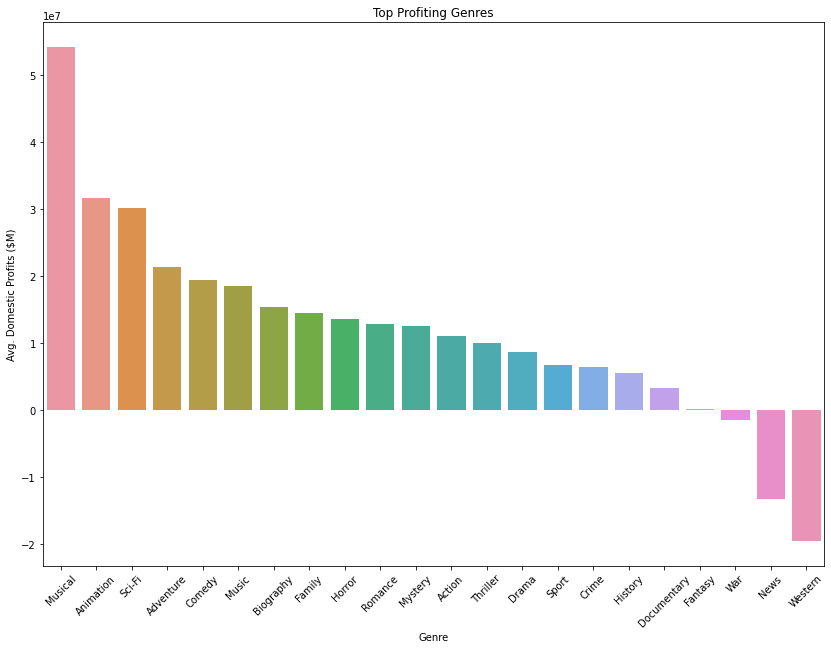

In [239]:
df_genre.sort_values(by = 'domestic_profit', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'movie_genres', y = 'domestic_profit', data = df_genre)
ax.set_title('Top Profiting Genres')

ax.set_xlabel('Genre')
ax.set_ylabel('Avg. Domestic Profits ($M)')
plt.xticks(rotation=45);


In [240]:
df['month'] = df['release_date'].dt.month
df_month = df.groupby('month').mean().apply(lambda s: s.apply('{0:.2f}'.format))
df_month.reset_index(inplace = True)
df_month.replace(1, 'January', inplace = True)
df_month.replace(2, 'February', inplace = True)
df_month.replace(3, 'March', inplace = True)
df_month.replace(4, 'April', inplace = True)
df_month.replace(5, 'May', inplace = True)
df_month.replace(6, 'June', inplace = True)
df_month.replace(7, 'July', inplace = True)
df_month.replace(8, 'August', inplace = True)
df_month.replace(9, 'September', inplace = True)
df_month.replace(10, 'October', inplace = True)
df_month.replace(11, 'November', inplace = True)
df_month.replace(12, 'December', inplace = True)
df_month['worldwide_profit'] = df_month['worldwide_profit'].astype(float)
df_month['domestic_profit'] = df_month['domestic_profit'].astype(float)
df_month['foreign_profit'] = df_month['foreign_profit'].astype(float)
df_month['average_rating'] = df_month['average_rating'].astype(float)
df_month['num_votes'] = df_month['num_votes'].astype(float)
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   month             12 non-null     object 
 1   worldwide_profit  12 non-null     float64
 2   domestic_profit   12 non-null     float64
 3   average_rating    12 non-null     float64
 4   num_votes         12 non-null     float64
 5   foreign_profit    12 non-null     float64
dtypes: float64(5), object(1)
memory usage: 704.0+ bytes


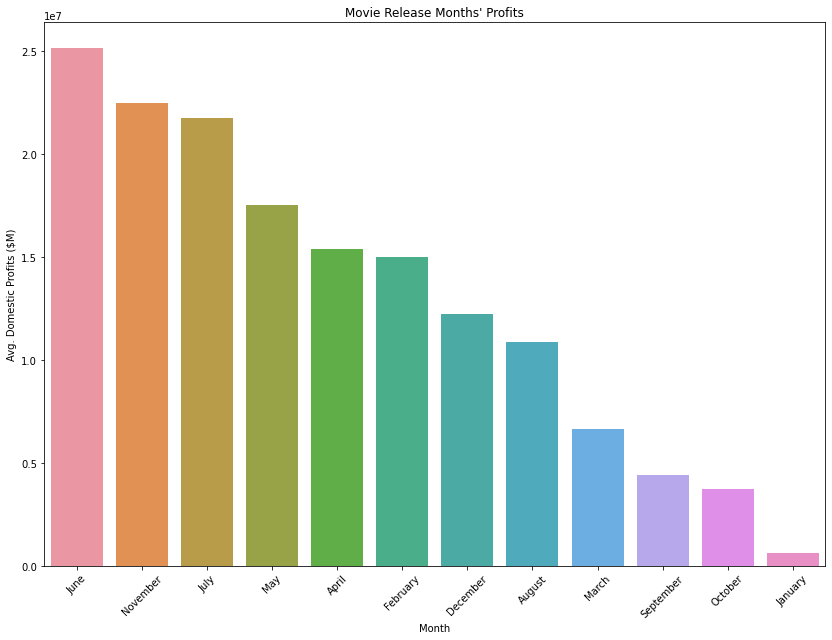

In [242]:
df_month.sort_values(by = 'domestic_profit', ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'month', y = 'domestic_profit', data = df_month)
ax.set_title("Movie Release Months' Profits")

ax.set_xlabel('Month')
ax.set_ylabel('Avg. Domestic Profits ($M)')
plt.xticks(rotation=45);

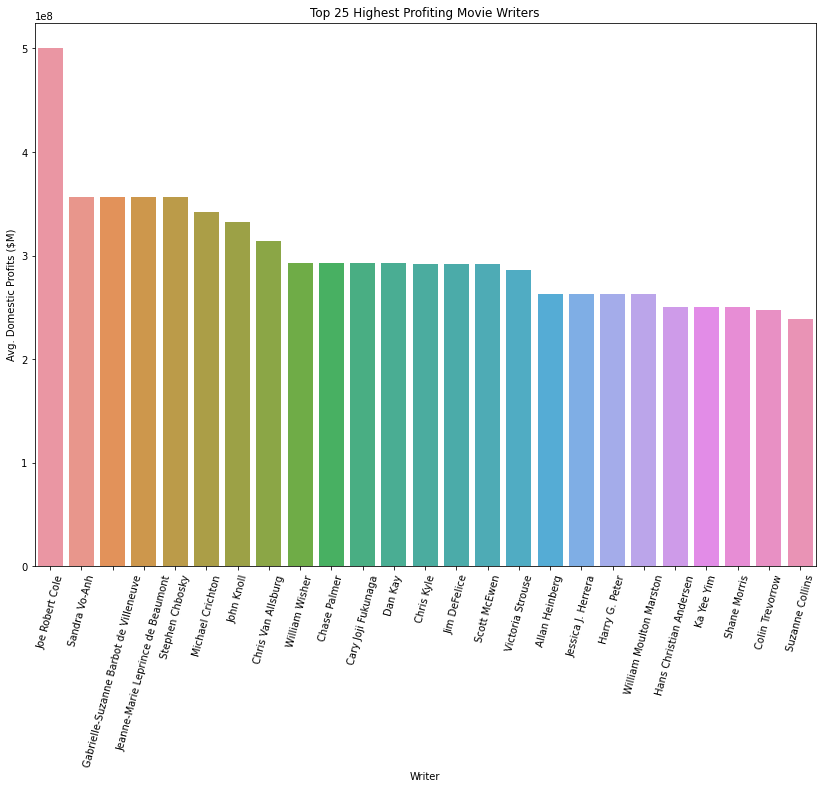

In [245]:
fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'writer', y = 'domestic_profit', data = df_top25_writers)
ax.set_title('Top 25 Highest Profiting Movie Writers')

ax.set_xlabel('Writer')
ax.set_ylabel('Avg. Domestic Profits ($M)')
plt.xticks(rotation=75);


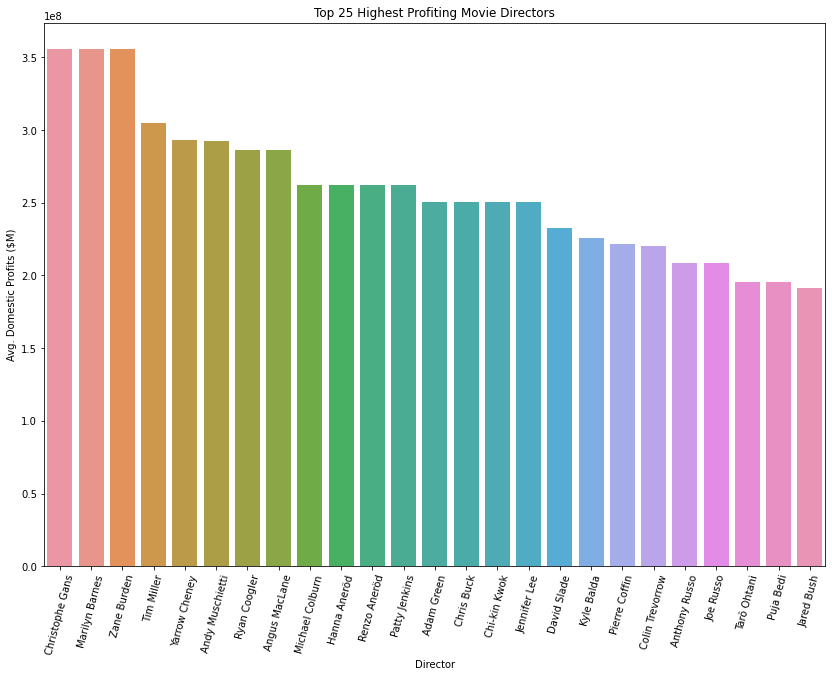

In [247]:
fig, ax = plt.subplots(figsize = (14,10))
sns.barplot(x = 'director', y = 'domestic_profit', data = df_top25_directors)
ax.set_title('Top 25 Highest Profiting Movie Directors')

ax.set_xlabel('Director')
ax.set_ylabel('Avg. Domestic Profits ($M)')
plt.xticks(rotation=75);
